In [1]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, StopTrainingOnRewardThreshold, EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
warnings.filterwarnings("ignore")

In [2]:
class BobinaEnvTest(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -np.inf, -np.inf, -45, -45]), high = np.array([10, 10, np.inf, np.inf, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(15.3, 17.3)
    self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0


  def step(self, action):
    # Apply action
    self.state, self.crash, angulo, error = self.sistema.step(action[0],action[1])
    self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    reward = -abs(self.distancia1) -abs(self.distancia2) - 10000*self.crash

    """if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)"""

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[1] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(9.5, 22)
    #self.state = np.array([airgap - 16.3, airgap - 16.3, 0, 0, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    angulo = random.uniform(-0.008, 0.008)
    self.vel = random.uniform(-0.2, 0.2)
    self.velangular = random.uniform(-0.3, 0.3)
    self.current1 = 0
    self.current2 = 0
    airgap1, airgap2 = self.sistema.pos2airgap(pos = airgap, theta = angulo)
    self.distancia1, self.distancia2 = airgap1-16.3, airgap2-16.3
    self.state= self.distancia1, self.distancia2, self.vel, self.velangular, self.current1, self.current2
    self.sistema.integral_aceleracion = self.vel
    self.sistema.integral_alpha = self.velangular
    self.sistema.integral_omega = angulo
    self.state, self.crash = self.sistema.step(0,0)
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [156]:
class TestSpeedEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap + variacion - 16.3, airgap - 16.3, airgap + variacion - 16.3, 0, 0])
    self.airgapinicial = airgap + variacion
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.sistema.integral_aceleracion = variacion
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap 
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = variacion
    self.velangular = 0
    self.prev_error = (airgap - 16.3/7.3)**2


  def step(self, action):
    # Apply action
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    error = ((self.distancia12/7.3)**2 + (self.distancia22/7.3)**2)/2
    reward_raw = 1 - error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[2] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.uniform(10, 21.5)
    variacion = random.uniform(-0.06, 0.06)
    self.state = np.array([airgap - 16.3, airgap + variacion - 16.3, airgap - 16.3, airgap + variacion - 16.3, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    self.sistema.integral_aceleracion = variacion
    self.vel = variacion
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [96]:
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just two degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap = 16.3, duration = 10, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100]), high = np.array([100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([-10, -10, -10, -10, -45, -45]), high = np.array([10, 10, 10, 10, 45, 45]), dtype=np.float32)
    # Initial parameters
    airgap = random.choice([10, 22])
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap - 16.3, airgap - 16.3, 0, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = self.airgapinicial, dist_cm = dist_cm, inercia= inercia, min_distance = min_distance, max_distance = max_distance)
    self.steps = []
    self.airgap1 = airgap
    self.airgap2 = airgap
    self.distancia1 = 0
    self.distancia2 = 0
    self.velocidad = 0
    self.current1 = 0
    self.current2 = 0
    self.alive = alive
    self.vel = 0
    self.velangular = 0
    self.prev_error = (airgap - 16.3/7.3)**2


  def step(self, action):
    # Apply action
    self.state, self.crash = self.sistema.step(action[0],action[1])
    self.distancia11, self.distancia12, self.distancia21, self.distancia22, self.current1, self.current2 = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    error = ((self.distancia12/7.3)**2 + (self.distancia22/7.3)**2)/2
    reward_raw = 1 - error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    """if self.crash:
      reward = - 100000
      terminated = True
    else:
      terminated = False"""
    terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes", normalize = True, seed = 0):
    # create data
    x = list(range(0,len(self.steps)))
    y1 = [16.3+step[0] for step in self.steps]
    y2 = [16.3+step[2] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black
    if normalize: ax.set_ylim(bottom=8, top=23)
    plt.xlabel("Time (s)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("Airgap evolution") #, color='white')

    plt.plot(x, y1, label = "Airgap 1")
    plt.plot(x, y2, label = "Airgap 2")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    #if self.steps[0][0] < 0: plt.savefig("images/top-2gdl8x8nocrash.png")
    #else: plt.savefig("images/bottom-2gdl8x8nocrash.png")
    plt.savefig(f"images/2gdl8x8nocrashsituation{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([9, 22.5])
    self.state = np.array([airgap - 16.3, airgap - 16.3, airgap - 16.3, airgap - 16.3, 0, 0])
    self.sistema = TwoGDL(masa_pod = self.masa_pod, airgap = airgap, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5)
    
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [4]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5, min_distance = 9, max_distance = 22.5):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = min_distance
    self.max_distance = max_distance
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [35]:
class TwoGDL():
    def __init__(self, masa_pod = 250, airgap = 22.5, dist_cm = 0.7, inercia= 70, min_distance = 9, max_distance = 22.5):
        self.masa_pod = masa_pod
        self.airgap1 = airgap
        self.airgap1_list = [airgap, airgap]
        self.airgap2 = airgap
        self.airgap2_list = [airgap, airgap]
        self.dist_cm = dist_cm
        self.inercia = inercia
        self.airgapinicial = airgap
        self.min_distance = min_distance
        self.max_distance = max_distance
        self.b1 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap1, min_distance = self.min_distance, max_distance = self.max_distance)
        self.b2 = Bobina(masa_pod = self.masa_pod, airgap = self.airgap2, min_distance = self.min_distance, max_distance = self.max_distance)
        self.crash = False
        self.angulo = [0]
        self.alpha = [0]
        self.integral_alpha = 0
        self.omega = [0]
        self.integral_omega = 0
        self.altura = [0]
        self.aceleracion = [0]
        self.integral_aceleracion = 0
        self.velocidad = [0]
        self.integral_velocidad = 0
    
    def integral(self, lista, h = 1):
        return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
    
    def fast_integral(self, last, lista, h = 0.001):
        return last + h*(lista[-1]+lista[-2])/2
    
    def get_angulo(self, f1, f2):
        F1 = f1*self.dist_cm
        F2 = -f2*self.dist_cm
        M = F1+F2
        alpha = M/self.inercia
        self.alpha.append(alpha)
        omega = self.fast_integral(self.integral_alpha, self.alpha, 0.001)
        self.integral_alpha = omega
        self.omega.append(omega)
        angulo = self.fast_integral(self.integral_omega, self.omega, 0.001)
        self.integral_omega = angulo
        self.angulo.append(angulo)
        return angulo
    
    def get_altura(self, f1, f2):
        F = (self.masa_pod/2)*9.8 - f1 - f2
        a = F/(self.masa_pod/2)
        self.aceleracion.append(a)
        v = self.fast_integral(self.integral_aceleracion, self.aceleracion, 0.001)
        self.integral_aceleracion = v
        self.velocidad.append(v)
        zpos = self.fast_integral(self.integral_velocidad,self.velocidad, 0.001)
        self.integral_velocidad = zpos
        zpos = self.airgapinicial + zpos*1000
        self.altura.append(zpos)
        return zpos
    
    def pos2airgap(self, pos, theta):
        airgap1 = pos + self.dist_cm*math.sin(theta)*1000
        airgap2 = pos - self.dist_cm*math.sin(theta)*1000
        return airgap1, airgap2
    
    def step(self, target_voltage1, target_voltage2, verbose = False):
        # Calculate vertical force and current
        self.crash = False
        vertical_force1, current1 = self.b1.vertical_force(airgap = self.airgap1, target_voltage = target_voltage1, temperature = 40)
        vertical_force2, current2 = self.b2.vertical_force(airgap = self.airgap2, target_voltage = target_voltage2, temperature = 40)
        if verbose: print("Fuerza vertical 1: ", vertical_force1)
        if verbose: print("Fuerza vertical 2: ", vertical_force2)
        angulo = self.get_angulo(f1 = vertical_force1, f2 = vertical_force2)
        zpos = self.get_altura(f1 = vertical_force1, f2 = vertical_force2)
        self.airgap1, self.airgap2 = self.pos2airgap(pos = zpos, theta = angulo)
        self.airgap1_list.append(self.airgap1)
        self.airgap2_list.append(self.airgap2)
        if verbose: print("Airgap 1: ", self.airgap1)
        if verbose: print("Airgap 2: ", self.airgap2)
        if self.airgap1 > self.max_distance or self.airgap2 > self.max_distance:
            self.airgap1 = self.max_distance
            self.airgap2 = self.max_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.max_distance
        elif self.airgap1 < self.min_distance or self.airgap2 < self.min_distance:
            self.airgap1 = self.min_distance
            self.airgap2 = self.min_distance
            self.crash = True
            self.angulo = [0]
            self.alpha = [0]
            self.integral_alpha = 0
            self.omega = [0]
            self.integral_omega = 0
            self.altura = [0]
            self.aceleracion = [0]
            self.integral_aceleracion = 0
            self.velocidad = [0]
            self.integral_velocidad = 0
            self.airgapinicial = self.min_distance
        #return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(current1), np.float32(current2)), self.crash
        #return (np.float32(self.airgap1 -16.3), np.float32(self.airgap2-16.3), np.float32(self.integral_aceleracion), np.float32(self.integral_alpha), np.float32(current1), np.float32(current2)), self.crash, angulo, zpos - 16.3
        return (np.float32(self.airgap1_list[-2] -16.3), np.float32(self.airgap1_list[-1] -16.3), np.float32(self.airgap2_list[-2] -16.3), np.float32(self.airgap2_list[-1] -16.3), np.float32(current1), np.float32(current2)), self.crash
        #añadir una que returnee los 2 errores y las 2 velocidades


In [90]:
run = wandb.init(
    project="2gdl",
    sync_tensorboard=True,
    monitor_gym=True,
)

global_step,▁▂▂▃▄▄▅▆▇▇█
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,█▆▃▃▂▂▁▂▂▂▁
time/fps,▁▁▁▁▁▁▁▁▁▁▁
train/actor_loss,▇▁▃▆▇██████
train/critic_loss,▅▆██▄▂▅▃▁▁▁
train/ent_coef,▃▇█▅▃▂▁▂▂▁▁
train/ent_coef_loss,█▄▂▂▂▃▁▃▁▂▃
train/learning_rate,█▇▇▆▅▅▄▃▂▂▁
global_step,220000
rollout/ep_len_mean,5000.0


In [91]:
# Create log dir
log_dir = "2gdl/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( duration = 5 )
env = Monitor(env, log_dir)

In [52]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
policy_kwargs = dict(net_arch=dict(pi=[8, 8], qf=[256, 256]))
model = SAC("MlpPolicy", env,learning_rate = linear_schedule(0.001), policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir, device="auto")

Using cuda device
Wrapping the env in a DummyVecEnv.


In [93]:
MODEL_PATH = f"models/2gdl8x8fs-passalis13a19/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.00001))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [94]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="2gdl"
)


callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=5900, verbose=1)
eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=1)


In [95]:
# Train the agent
model.learn(total_timesteps=10000000,
    callback=[
        checkpoint_callback,
        #eval_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/2gdl8x8fs-passalis10a22",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 2gdl/SAC_59
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5e+03    |
|    ep_rew_mean     | 3.68e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 33       |
|    time_elapsed    | 598      |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -75.3    |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.0069   |
|    ent_coef_loss   | 9.4      |
|    learning_rate   | 9.98e-06 |
|    n_updates       | 2349697  |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5e+03    |
|    ep_rew_mean     | 1.51e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 33       |
|    time_elapsed    | 1199     |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -40.7    |
|    critic_loss     | 0.

KeyboardInterrupt: 

In [24]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-57087.66697450366
Episode:2 Score:-57169.60609087738
Episode:3 Score:-57424.86711319699


In [109]:
b = Bobina()
b.airgap = 9

In [108]:
b.step(100)

((20.00214, -0.10582279, 3.7021403, 45.0), False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-2.17691588 -2.1183128  -2.17691588 -2.1183128   0.          0.        ]
Time predict 13.357494354248047
Time model 54.775402307510376
Episode reward 5026.673531028502
[(0.0, 0.0), (-3.162985, -3.1656818), (-5.5771337, -6.1826653), (-5.1856995, -8.899724), (-2.6053264, -10.733742), (-0.62234247, -9.835582), (-1.0501384, -7.0257483), (-2.9138837, -6.5353246), (-2.9006279, -8.441722), (-1.383992, -8.510232), (-1.5045973, -6.360224), (-3.0524514, -5.9375563), (-3.1365395, -7.6409883), (-1.8604236, -7.6057706), (-1.8727436, -5.5031896), (-3.1388576, -5.2031245), (-3.2142758, -6.9736805), (-2.1135476, -6.8711967), (-2.0995774, -4.694661), (-3.1471856, -4.4772525), (-3.1565368, -6.36393), (-2.189658, -6.2286773), (-2.1998577, -3.9641314), (-3.0735755, -3.7841697), (-2.9931052, -5.763928), (-2.137981, -5.6370115), (-2.2001662, -3.3354862), (-2.920375, -3.171676), (-2.7390232, -5.20724), (-1.9938083, -5.0646925), (-2

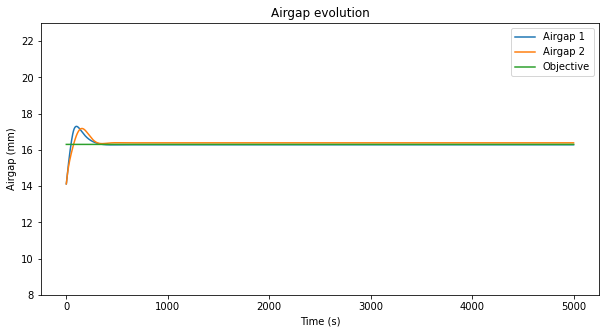

[1.62800281 1.66642027 1.62800281 1.66642027 0.         0.        ]
Time predict 14.612309217453003
Time model 54.08966040611267
Episode reward 5018.765829934812
[(0.0, 0.0), (3.0058281, 3.0058293), (6.0348372, 6.0348406), (9.090854, 9.090887), (12.136551, 12.136922), (15.158211, 15.159461), (18.205534, 18.207975), (21.302298, 20.559286), (24.23991, 19.074732), (22.816505, 15.252798), (17.89773, 15.262356), (17.268728, 18.33956), (20.306915, 21.2242), (23.3874, 20.20725), (22.624144, 15.736019), (18.025509, 15.179944), (16.996027, 18.275), (19.788969, 21.306322), (22.833536, 20.525723), (23.090027, 16.05998), (19.142553, 15.365853), (16.353405, 18.357744), (17.72686, 21.332806), (20.752012, 20.815458), (23.650482, 16.640135), (22.222525, 15.987186), (16.750183, 19.011942), (15.5779085, 21.896894), (18.603064, 21.016218), (21.635181, 16.548594), (20.575113, 15.868833), (15.545124, 18.903788), (14.598822, 21.832699), (17.61218, 20.894047), (20.638536, 16.371634), (19.684813, 15.701343), 

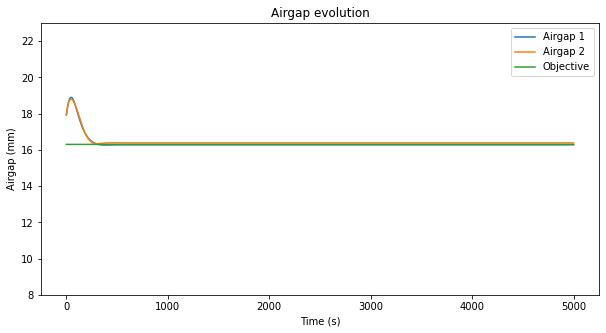

[1.66074723 1.67369637 1.66074723 1.67369637 0.         0.        ]
Time predict 14.388235569000244
Time model 54.556702852249146
Episode reward 5021.125381748951
[(0.0, 0.0), (3.0058215, 3.0058293), (6.0347667, 6.0348406), (9.090695, 9.092527), (12.086067, 12.140147), (14.814843, 15.15122), (17.23099, 14.884414), (16.901562, 11.279163), (12.96335, 10.933368), (9.98951, 13.943103), (10.978883, 16.70115), (13.99608, 15.51934), (16.795673, 11.005363), (15.606575, 10.42604), (10.773772, 13.43782), (9.876082, 16.296867), (12.849241, 15.409719), (15.76815, 11.206155), (14.822117, 10.742698), (10.242153, 13.756908), (9.480817, 16.378935), (12.456767, 15.158714), (15.307611, 10.898607), (14.347485, 10.47233), (9.930648, 13.480244), (9.280106, 16.070147), (12.250125, 14.839111), (15.014472, 10.594222), (13.977566, 10.178331), (9.619673, 13.19189), (9.012617, 15.63945), (11.98539, 14.286278), (14.560052, 10.280233), (13.368631, 10.056508), (9.215009, 13.039285), (8.77559, 14.889139), (11.750081

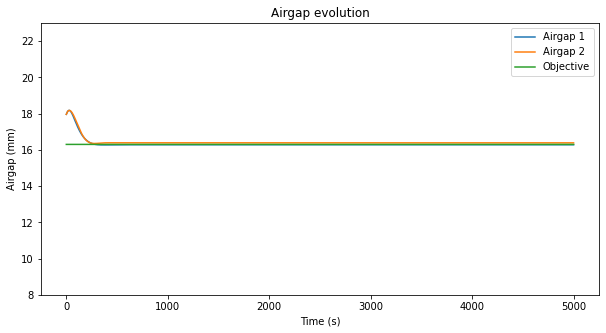

[2.3087993  2.35737635 2.3087993  2.35737635 0.         0.        ]
Time predict 13.706049680709839
Time model 54.551876068115234
Episode reward 5010.390992297966
[(0.0, 0.0), (2.9903378, 2.9903378), (5.9878497, 5.9878497), (9.002369, 9.002369), (12.019204, 12.019204), (15.017028, 15.017031), (18.009554, 18.009563), (21.040613, 21.04063), (24.095392, 24.095427), (27.059532, 27.057417), (29.836, 29.73322), (28.480064, 29.819561), (26.248995, 27.696884), (28.092396, 27.846722), (30.573038, 29.916183), (28.676155, 29.181927), (26.070782, 27.114214), (27.849297, 27.952684), (30.479542, 29.984375), (28.777973, 28.78536), (26.120619, 26.501299), (27.795132, 27.504715), (30.442356, 29.662981), (28.745499, 28.482758), (26.025476, 26.029661), (27.651129, 26.936974), (30.313381, 29.193502), (28.63379, 28.111547), (25.81957, 25.534204), (27.347908, 26.359766), (30.03658, 28.725935), (28.41021, 27.639214), (25.572826, 24.89655), (27.03773, 25.6495), (29.688068, 28.321918), (28.059916, 27.343555), 

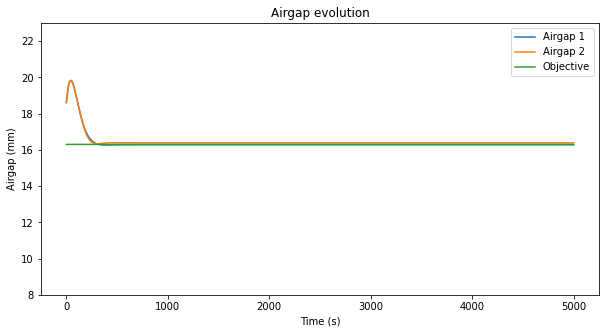

[-5.22619448 -5.17947476 -5.22619448 -5.17947476  0.          0.        ]
Time predict 14.411921977996826
Time model 54.256986141204834
Episode reward 5019.903280729408
[(0.0, 0.0), (-3.267957, -3.2679229), (-6.4028206, -6.4027596), (-9.252628, -9.252554), (-11.810808, -11.810726), (-14.111861, -14.111773), (-16.228481, -16.228386), (-18.216787, -18.216682), (-20.089258, -20.089148), (-21.858253, -21.85814), (-23.536905, -23.536774), (-25.137253, -25.136469), (-26.67062, -26.658777), (-28.146315, -27.986572), (-29.56768, -28.385204), (-30.93664, -27.66726), (-32.248657, -27.357025), (-33.489643, -28.021605), (-34.61454, -28.52092), (-35.549274, -28.525969), (-36.136925, -28.5372), (-36.227104, -28.716227), (-35.921936, -28.903786), (-35.496696, -28.934114), (-35.123894, -28.769112), (-34.79684, -28.493307), (-34.45001, -28.209187), (-34.058586, -27.95316), (-33.642563, -27.704992), (-33.025505, -27.474209), (-32.06051, -27.256052), (-30.959978, -26.956688), (-29.95629, -26.512003), (-2

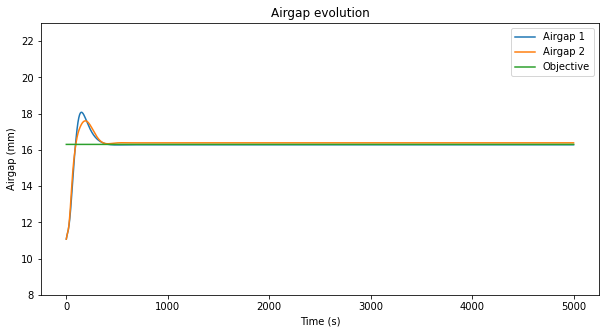

[-2.67504615 -2.73197155 -2.67504615 -2.73197155  0.          0.        ]
Time predict 12.205214738845825
Time model 54.94270706176758
Episode reward 5003.217711836857
[(0.0, 0.0), (-3.1658266, -3.166177), (-6.1863823, -6.187213), (-8.918337, -8.919893), (-11.400591, -11.403328), (-13.701751, -13.70607), (-15.849244, -15.85673), (-17.858068, -17.871758), (-19.753044, -19.773558), (-21.54561, -21.472078), (-23.248219, -21.61119), (-24.857107, -20.48494), (-26.284517, -20.767632), (-27.451017, -22.292984), (-28.368721, -23.257166), (-29.021425, -23.219147), (-29.336561, -23.219368), (-29.378162, -23.98563), (-29.592356, -24.836191), (-30.165384, -25.285322), (-30.781967, -25.473703), (-31.240818, -25.657146), (-31.540716, -25.893993), (-31.766447, -26.129496), (-31.98317, -26.317333), (-32.206127, -26.457207), (-32.423023, -26.572472), (-32.62213, -26.680693), (-32.801487, -26.784834), (-32.96475, -26.880198), (-33.11512, -26.962635), (-33.25316, -27.031336), (-33.37802, -27.087318), (-3

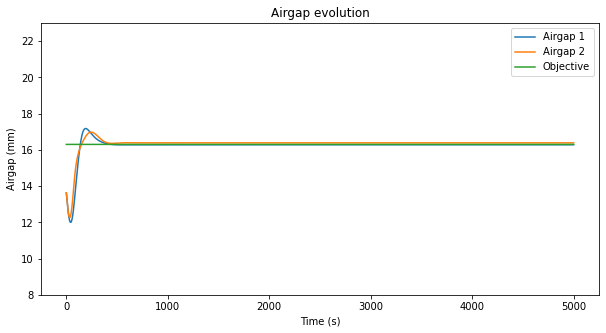

[-2.46496215 -2.52486938 -2.46496215 -2.52486938  0.          0.        ]
Time predict 10.955148458480835
Time model 54.62972688674927
Episode reward 5003.93600987103
[(0.0, 0.0), (-3.1659205, -3.1662292), (-6.1865964, -6.1873083), (-8.91145, -8.912744), (-11.386692, -11.388945), (-13.6903925, -13.693347), (-15.841474, -15.845655), (-17.845066, -17.856276), (-19.72092, -19.720835), (-21.481142, -21.115278), (-23.139853, -20.662243), (-24.635418, -19.726461), (-25.735275, -20.564358), (-26.495956, -21.951525), (-27.289598, -21.601833), (-27.967306, -20.681498), (-28.12941, -21.455912), (-28.049639, -22.910145), (-28.247751, -23.518747), (-28.746933, -23.174997), (-29.100134, -23.269733), (-29.159325, -24.166588), (-29.471321, -24.916483), (-30.113186, -25.195532), (-30.678026, -25.323202), (-31.049957, -25.504524), (-31.27942, -25.729576), (-31.465769, -25.92402), (-31.660069, -26.05564), (-31.85997, -26.143341), (-32.04703, -26.218113), (-32.212395, -26.29257), (-32.358463, -26.362938)

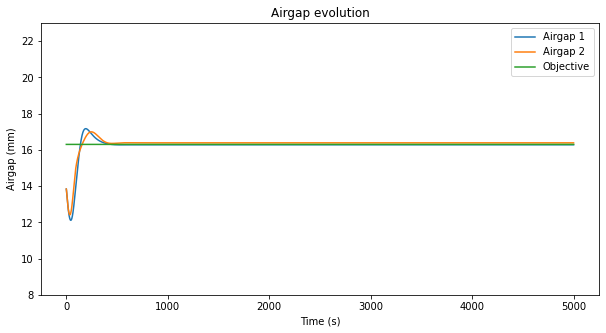

[-0.83759789 -0.88808919 -0.83759789 -0.88808919  0.          0.        ]
Time predict 11.28268551826477
Time model 55.47819757461548
Episode reward 5068.009584034572
[(0.0, 0.0), (-3.1065116, -3.1126966), (-6.058933, -6.0718126), (-8.742139, -8.75809), (-11.214728, -11.2350235), (-13.381451, -13.500121), (-14.057012, -14.785164), (-13.008187, -13.625821), (-12.300884, -11.837784), (-12.806266, -12.443413), (-13.371564, -14.238106), (-13.239478, -13.635523), (-12.841116, -11.184603), (-12.636837, -11.194215), (-12.732783, -13.349451), (-13.096764, -13.296912), (-13.245573, -11.024377), (-12.744133, -10.93588), (-12.338859, -13.056215), (-12.843653, -12.937105), (-13.434197, -10.623522), (-12.915944, -10.568297), (-12.121803, -12.724778), (-12.542444, -12.662354), (-13.451894, -10.395123), (-13.115001, -10.357943), (-12.094434, -12.537144), (-12.324944, -12.470356), (-13.386713, -10.165506), (-13.239498, -10.116443), (-12.1406145, -12.320323), (-12.217667, -12.318827), (-13.298037, -10.

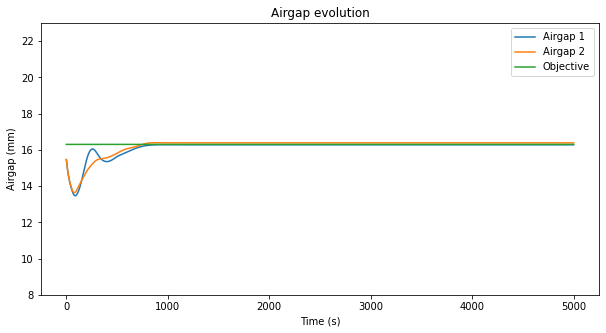

[5.02065127 5.02859678 5.02065127 5.02859678 0.         0.        ]
Time predict 11.024108171463013
Time model 55.3797972202301
Episode reward 5002.210266310972
[(0.0, 0.0), (2.9987578, 2.9987578), (5.9726167, 5.9726167), (8.910258, 8.910258), (11.851131, 11.851131), (14.803347, 14.803347), (17.739965, 17.739965), (20.660479, 20.660479), (23.613747, 23.613747), (26.572945, 26.572945), (29.420267, 29.420269), (32.113937, 32.113945), (34.65239, 34.65241), (37.03639, 37.036434), (39.27974, 39.28092), (40.822693, 41.392456), (38.119907, 43.36467), (35.960133, 45.0), (38.07584, 45.0), (40.167168, 45.0), (38.258156, 42.85626), (36.230995, 41.41824), (38.196033, 42.65954), (40.084446, 43.398113), (37.6951, 41.243366), (35.463818, 39.564827), (37.533085, 40.849525), (39.581264, 41.76771), (37.365116, 39.57832), (35.107674, 37.68877), (37.125053, 38.964302), (39.12918, 40.036694), (36.800213, 37.891693), (34.48266, 35.894947), (36.51414, 37.205265), (38.53086, 38.357346), (36.18216, 36.104298),

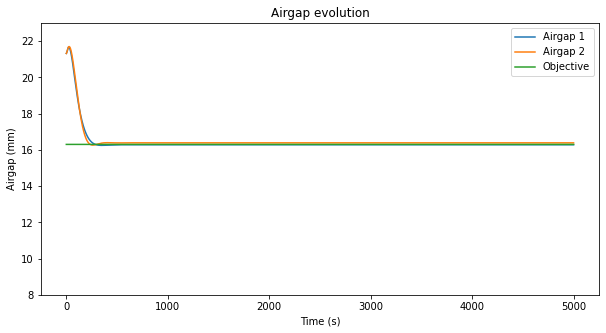

[-6.19155994 -6.15492569 -6.19155994 -6.15492569  0.          0.        ]
Time predict 11.01005244255066
Time model 55.51371502876282
Episode reward 4996.781385539642
[(0.0, 0.0), (-3.29866, -3.2985919), (-6.4635663, -6.4634438), (-9.347788, -9.347636), (-11.949519, -11.949353), (-14.278662, -14.278488), (-16.396332, -16.396156), (-18.376333, -18.376154), (-20.23937, -20.23919), (-21.994637, -21.99445), (-23.652817, -23.652626), (-25.230959, -25.230764), (-26.740316, -26.740118), (-28.18819, -28.187988), (-29.581224, -29.580978), (-30.92475, -30.924059), (-32.22292, -32.218376), (-33.47959, -33.444466), (-34.696156, -34.452896), (-35.873802, -34.778183), (-37.013817, -34.416084), (-38.11765, -34.287243), (-39.186047, -34.712612), (-40.219585, -35.086536), (-41.21809, -35.03589), (-42.178596, -34.869957), (-43.091835, -34.9923), (-43.93896, -35.240955), (-44.69435, -35.299362), (-45.0, -35.225433), (-45.0, -35.191875), (-45.0, -35.153885), (-45.0, -35.081192), (-45.0, -35.014412), (-45.

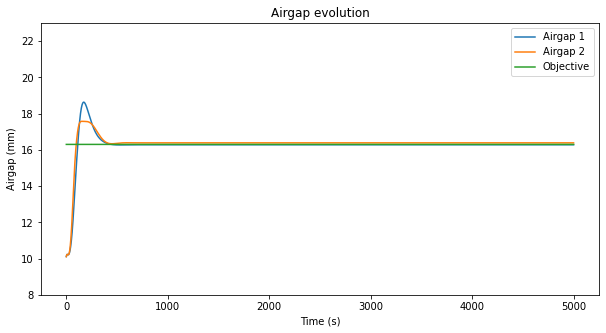

: 

In [160]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/2gdl8x8fs-passalis13a19/model.zip"

# Create and wrap the environment
env = TestSpeedEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(10):
    obs, seed = env.reset()
    print(obs)
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    timepredict = 0
    timemodel = 0
    distancia11, distancia12, distancia21, distancia22, current1, current2 = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([distancia11, distancia12, distancia21, distancia22, current1, current2]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        distancia11, distancia12, distancia21, distancia22, current1, current2 = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append((current1, current2))
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes", normalize = True, seed = f"speedpassalis{i}")

In [1]:
plt.savefig("images/floor-2gdl8x8nocrash.png")

NameError: name 'plt' is not defined

: 

In [167]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/sac8x8h9.3/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "./ONNX/1gdlComplexH98x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "./ONNX/1gdlComplexH98x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



: 

In [12]:
model.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=8, out_features=1, bias=True)
    (log_std): Linear(in_features=8, out_features=1, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
   

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)